In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from joblib import Parallel
import numpy as np


In [3]:
cpu_util_df = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_cpu_utilization_53ea38.csv")
cpu_util_df.head()

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


In [21]:
cpu_util_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [4]:
cpu_util_df["timestamp"]=pd.to_datetime(cpu_util_df["timestamp"])


<Axes: xlabel='timestamp'>

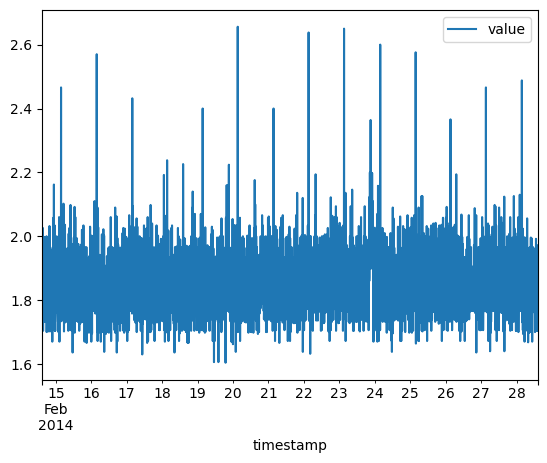

In [12]:
cpu_util_df.plot.line(x='timestamp',y='value')

In [51]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed

# Max values for p, d, and q
max_p, max_d, max_q = 5, 2, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets

def find_aic_for_model(data, p, d, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order (p, d, q) = ({p}, {d}, {q})"
        print(msg)
        
        # Avoid refitting if p=0, d=0, and q=1
        if (p, d, q) == (0, 0, 1):
            return None, (p, d, q)
        
        # Fit ARIMA model
        ts_results = model(data, order=(p, d, q)).fit()
        curr_aic = ts_results.aic
        return curr_aic, (p, d, q)
    
    except Exception as e:
        print(f"Exception occurred for (p, d, q) = ({p}, {d}, {q}): {e}")
        return None, (p, d, q)

def find_best_order_for_model(data, model, model_name):
    p_ar, d_diff, q_ma = max_p, max_d, max_q
    final_results = []

    # Initial fit with ARIMA(0, 1, 0)
    ts_results = model(data, order=(0, 1, 0)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 1, 0)))
    
    # Create order sets for q values
    order_sets = get_order_sets(q_ma + 1, 5)  # Include q=5 as well

    for p in range(0, p_ar + 1):
        for d in range(0, d_diff + 1):
            for order_set in order_sets:
                # Fit the model and find AIC in parallel for different q values
                results = Parallel(n_jobs=len(order_set), prefer='threads')(
                    delayed(find_aic_for_model)(data, p, d, q, model, model_name)
                    for q in order_set
                )
                final_results.extend(results)
    
    # Create a DataFrame with results
    results_df = pd.DataFrame(
        [res for res in final_results if res[0] is not None],
        columns=['aic', 'order']
    )

    # Find the order with the minimum AIC
    min_df = results_df[results_df['aic'] == results_df['aic'].min()]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    
    return min_aic, min_order, results_df


In [52]:
# print(find_best_order_for_model(cpu_util_df["value"], ARIMA, "ARIMA"))
min_aic, min_order, results_df = find_best_order_for_model(cpu_util_df["value"], ARIMA, "ARIMA")
# print(find_best_order_for_model(cpu_util_df, ARIMA, "ARIMA"))
print("******MIN_AIC: ", min_aic, "MIN_ORDER: ", min_order)# Output: 1341.1035677173795, (4, 4)

Fitting ARIMA with order (p, d, q) = (0, 0, 0)
Fitting ARIMA with order (p, d, q) = (0, 0, 1)
Fitting ARIMA with order (p, d, q) = (0, 0, 2)
Fitting ARIMA with order (p, d, q) = (0, 0, 3)
Fitting ARIMA with order (p, d, q) = (0, 0, 4)
Fitting ARIMA with order (p, d, q) = (0, 0, 5)
Fitting ARIMA with order (p, d, q) = (0, 1, 0)
Fitting ARIMA with order (p, d, q) = (0, 1, 1)
Fitting ARIMA with order (p, d, q) = (0, 1, 2)
Fitting ARIMA with order (p, d, q) = (0, 1, 3)
Fitting ARIMA with order (p, d, q) = (0, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (0, 1, 5)
Fitting ARIMA with order (p, d, q) = (0, 2, 0)
Fitting ARIMA with order (p, d, q) = (0, 2, 1)
Fitting ARIMA with order (p, d, q) = (0, 2, 2)
Fitting ARIMA with order (p, d, q) = (0, 2, 3)
Fitting ARIMA with order (p, d, q) = (0, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (0, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 0, 0)Fitting ARIMA with order (p, d, q) = (1, 0, 1)
Fitting ARIMA with order (p, d, q) = (1, 0, 2)
Fitting ARIMA with order (p, d, q) = (1, 0, 3)

Fitting ARIMA with order (p, d, q) = (1, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (1, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (1, 1, 0)
Fitting ARIMA with order (p, d, q) = (1, 1, 1)
Fitting ARIMA with order (p, d, q) = (1, 1, 2)
Fitting ARIMA with order (p, d, q) = (1, 1, 3)
Fitting ARIMA with order (p, d, q) = (1, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

Fitting ARIMA with order (p, d, q) = (1, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 2, 0)Fitting ARIMA with order (p, d, q) = (1, 2, 1)
Fitting ARIMA with order (p, d, q) = (1, 2, 2)
Fitting ARIMA with order (p, d, q) = (1, 2, 3)
Fitting ARIMA with order (p, d, q) = (1, 2, 4)



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 0, 0)
Fitting ARIMA with order (p, d, q) = (2, 0, 1)
Fitting ARIMA with order (p, d, q) = (2, 0, 2)
Fitting ARIMA with order (p, d, q) = (2, 0, 3)
Fitting ARIMA with order (p, d, q) = (2, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/l

Fitting ARIMA with order (p, d, q) = (2, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 1, 0)Fitting ARIMA with order (p, d, q) = (2, 1, 1)

Fitting ARIMA with order (p, d, q) = (2, 1, 2)
Fitting ARIMA with order (p, d, q) = (2, 1, 3)
Fitting ARIMA with order (p, d, q) = (2, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users

Fitting ARIMA with order (p, d, q) = (2, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 2, 0)
Fitting ARIMA with order (p, d, q) = (2, 2, 1)
Fitting ARIMA with order (p, d, q) = (2, 2, 2)
Fitting ARIMA with order (p, d, q) = (2, 2, 3)
Fitting ARIMA with order (p, d, q) = (2, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users

Fitting ARIMA with order (p, d, q) = (2, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (3, 0, 0)
Fitting ARIMA with order (p, d, q) = (3, 0, 1)
Fitting ARIMA with order (p, d, q) = (3, 0, 2)
Fitting ARIMA with order (p, d, q) = (3, 0, 3)
Fitting ARIMA with order (p, d, q) = (3, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 1, 0)Fitting ARIMA with order (p, d, q) = (3, 1, 1)

Fitting ARIMA with order (p, d, q) = (3, 1, 2)
Fitting ARIMA with order (p, d, q) = (3, 1, 3)
Fitting ARIMA with order (p, d, q) = (3, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

Fitting ARIMA with order (p, d, q) = (3, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (3, 2, 0)Fitting ARIMA with order (p, d, q) = (3, 2, 1)
Fitting ARIMA with order (p, d, q) = (3, 2, 2)
Fitting ARIMA with order (p, d, q) = (3, 2, 3)
Fitting ARIMA with order (p, d, q) = (3, 2, 4)



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (4, 0, 0)
Fitting ARIMA with order (p, d, q) = (4, 0, 1)
Fitting ARIMA with order (p, d, q) = (4, 0, 2)
Fitting ARIMA with order (p, d, q) = (4, 0, 3)
Fitting ARIMA with order (p, d, q) = (4, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (4, 1, 0)Fitting ARIMA with order (p, d, q) = (4, 1, 1)

Fitting ARIMA with order (p, d, q) = (4, 1, 2)
Fitting ARIMA with order (p, d, q) = (4, 1, 3)
Fitting ARIMA with order (p, d, q) = (4, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fitting ARIMA with order (p, d, q) = (4, 2, 0)Fitting ARIMA with order (p, d, q) = (4, 2, 1)
Fitting ARIMA with order (p, d, q) = (4, 2, 2)

Fitting ARIMA with order (p, d, q) = (4, 2, 3)
Fitting ARIMA with order (p, d, q) = (4, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (5, 0, 0)Fitting ARIMA with order (p, d, q) = (5, 0, 1)
Fitting ARIMA with order (p, d, q) = (5, 0, 2)

Fitting ARIMA with order (p, d, q) = (5, 0, 3)
Fitting ARIMA with order (p, d, q) = (5, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (5, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fitting ARIMA with order (p, d, q) = (5, 1, 0)Fitting ARIMA with order (p, d, q) = (5, 1, 1)
Fitting ARIMA with order (p, d, q) = (5, 1, 2)
Fitting ARIMA with order (p, d, q) = (5, 1, 3)

Fitting ARIMA with order (p, d, q) = (5, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/an

Fitting ARIMA with order (p, d, q) = (5, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (5, 2, 0)
Fitting ARIMA with order (p, d, q) = (5, 2, 1)
Fitting ARIMA with order (p, d, q) = (5, 2, 2)
Fitting ARIMA with order (p, d, q) = (5, 2, 3)
Fitting ARIMA with order (p, d, q) = (5, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (5, 2, 5)
******MIN_AIC:  -9638.599360826622 MIN_ORDER:  (5, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
train_size = int(len(cpu_util_df) * 0.8)
train, test = cpu_util_df.iloc[:train_size], cpu_util_df.iloc[train_size:]

In [7]:

''' build arima model
ARIMA's parameters: p and q
p = for autoregression pt of model; how far back in time should we go to predict the current observation
q = for moving avg part of the model; represents num of lagged forecast errors included in the model 
'''
model_arima=ARIMA(train['value'],order=(5, 0, 5))
model_arima=model_arima.fit()



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
predictions = model_arima.predict(start=len(train), end=len(train) + len(test) - 1)
predictions.head()

3225    1.761090
3226    1.847984
3227    1.772914
3228    1.791703
3229    1.844580
Name: predicted_mean, dtype: float64

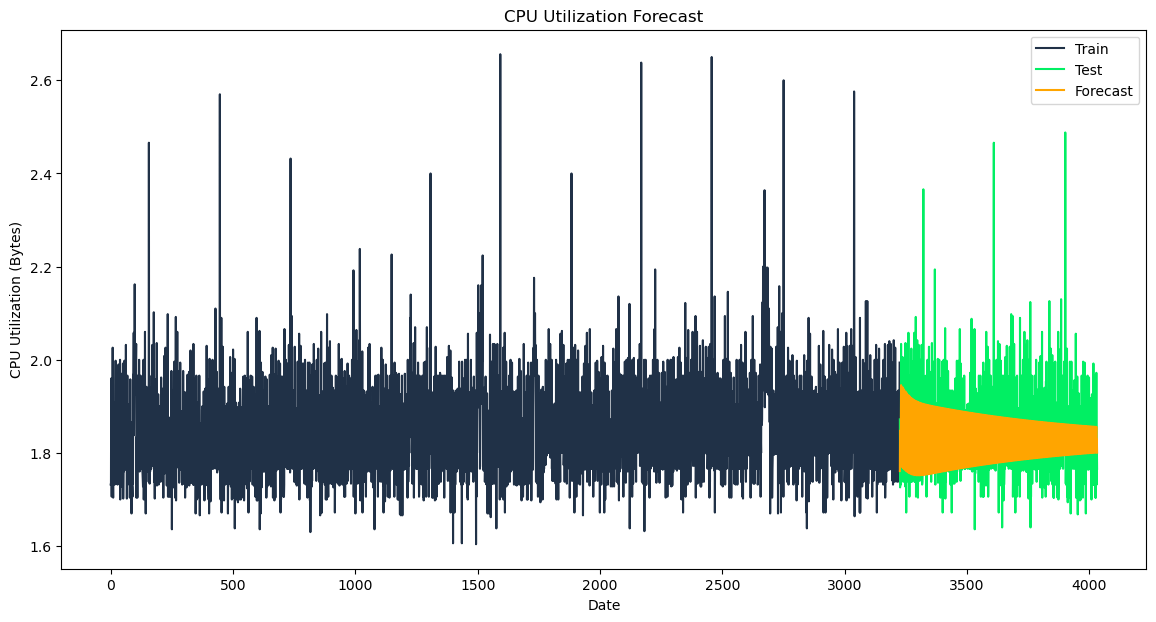

In [10]:
# Forecast
forecast = model_arima.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["value"], label='Train', color='#203147')
plt.plot(test.index, test["value"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('CPU Utilization Forecast')
plt.xlabel('Date')
plt.ylabel('CPU Utilization (Bytes)')
plt.legend()
plt.show()


In [11]:
print(f"AIC: {model_arima.aic}")
print(f"BIC: {model_arima.bic}")

AIC: -7262.43556641875
BIC: -7189.491307667991


In [12]:
forecast = forecast[:len(test)]
test_close = test["value"][:len(forecast)]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.0818


In [13]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [14]:
squared_errors = model_arima.resid ** 2
predictions, threshold = find_anomalies(squared_errors)

In [17]:
cpu_util_df["predictions"] = predictions
cpu_util_df.head(30)

,timestamp,value,predictions
0,2014-02-14 14:30:00,1.732,0.0
1,2014-02-14 14:35:00,1.732,0.0
2,2014-02-14 14:40:00,1.960,0.0
3,2014-02-14 14:45:00,1.732,0.0
4,2014-02-14 14:50:00,1.706,1.0
5,2014-02-14 14:55:00,1.734,0.0
6,2014-02-14 15:00:00,1.766,0.0
7,2014-02-14 15:05:00,1.766,0.0
8,2014-02-14 15:10:00,2.026,0.0
9,2014-02-14 15:15:00,1.762,0.0


In [18]:
cpu_util_df['predictions'].sum()

77.0